In [1]:
import utils
import ase.io
from scipy.spatial import Delaunay
from scipy.spatial import KDTree
import numpy as np

In [2]:
dump_file = "demo_dump/H_plane.dump"
atoms = ase.io.read(dump_file, format="lammps-dump-text")
W_mask = atoms.numbers == 1
H_mask = atoms.numbers == 2
atoms.numbers[W_mask] = 74
atoms.numbers[H_mask] = 1

In [3]:
xs = atoms.positions[:,0]
ys = atoms.positions[:,1]
zs = atoms.positions[:,2]
W_mask = (xs > -7) & (xs < 0.5) & (ys*ys+zs*zs<4000) & (atoms.numbers==74)
H_mask = (xs > -7) & (xs < 0.5) & (ys*ys+zs*zs<4000) & (atoms.numbers==1)

In [4]:
atoms[W_mask]

Atoms(symbols='W6345', pbc=True, cell=[188.4, 188.4, 188.4], c_1=..., c_2[1]=..., c_2[2]=..., c_2[3]=..., c_2[4]=..., c_2[5]=..., c_2[6]=..., c_3[1]=...)

In [5]:
def extract_tis(atoms):
    # extract all tis sites
    tets = Delaunay(atoms.positions)
    tises = []
    for sim in tets.simplices:
        sim_xyz = tets.points[sim]
        tis = np.mean(sim_xyz, axis=0)
        tises.append(tis)
    tises = np.array(tises)
    return tises, tets.simplices    
tises, simplices = extract_tis(atoms[W_mask])
# Delete occupied


tree = KDTree(atoms[H_mask].positions)
critical_distance = 2.5
to_delete = []
for i, point in enumerate(tises):
    distance, _ = tree.query(point)
    if distance < critical_distance:
        to_delete.append(i)
tises = np.delete(tises, to_delete, axis=0)
simplices = np.delete(simplices, to_delete, axis=0)

mask = (tises[:,0] < -1.3) & (tises[:,0] > -4.3) & (tises[:,1]**2+tises[:,2]**2<3000)
tises = tises[mask]

In [6]:
soaps = utils.Descriptors(atoms[atoms.numbers==74], tises)
model = utils.Model()
energy = model(soaps).reshape(-1).detach().cpu().numpy()

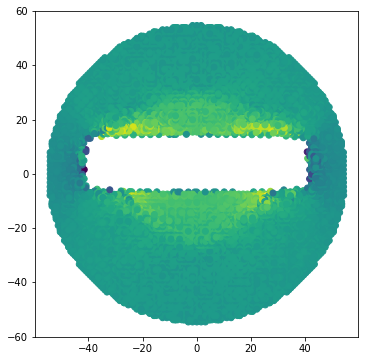

In [7]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1,figsize=(10,6))
ax.scatter(tises[:,1], tises[:,2], c=energy)
ax.set_aspect('equal',adjustable='box')